In [391]:
import numpy as np
import pandas as pd

amazon_df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

amazon_df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [393]:
amazon_df['category'] = amazon_df['category'].sort_values(ascending = False)
amazon_df['category'].value_counts()

category
Sports & Outdoors                         836265
Beauty                                     19312
Handmade Clothing, Shoes & Accessories     19229
Bath & Body                                19092
Birthday Gifts                             18978
                                           ...  
Motorbike Chassis                            107
Plugs                                        107
Alexa Built-In Devices                       107
Smart Home Security & Lighting               104
Smart Speakers                                54
Name: count, Length: 296, dtype: int64

In [394]:
#1.
crosstab_result = pd.crosstab(amazon_df['category'], amazon_df['isBestSeller'])

crosstab_result.columns = ['Not Best Seller', 'Best Seller']

crosstab_result['Total'] = crosstab_result['Not Best Seller'] + crosstab_result['Best Seller']
crosstab_result['Proportion Best Seller'] = (crosstab_result['Best Seller'] / crosstab_result['Total'])*100

sorted_crosstab = crosstab_result.sort_values(by='Proportion Best Seller', ascending=False)
display(sorted_crosstab)

,Not Best Seller,Best Seller,Total,Proportion Best Seller
category,,,,
Grocery,9008,556,9564,5.813467
Smart Home Security & Lighting,98,6,104,5.769231
Health & Personal Care,9017,552,9569,5.768628
Mobile Phone Accessories,248,11,259,4.247104
Power & Hand Tools,8353,306,8659,3.533895
...,...,...,...,...
Projectors,8698,0,8698,0.000000
Printer Accessories,254,0,254,0.000000
Power Supplies,247,0,247,0.000000


In [395]:
#2. **Statistical Tests**:
#Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

from scipy.stats import chi2_contingency  #stats is a section of the library

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(sorted_crosstab)

display(chi2_statistic, chi2_p_value) #p value = 0: there is no correlation between the number of best sellers and the category



50784.635515685426

0.0

In [396]:
#Compute Cramér's V to understand the strength of association between best-seller status and category.
from scipy.stats.contingency import association

sorted_crosstab_int = sorted_crosstab.astype(int)
cramer_v = association(sorted_crosstab_int, method="cramer")

print("Cramér's V:", cramer_v)

#0 indicates no association

Cramér's V: 0.06094695564155529


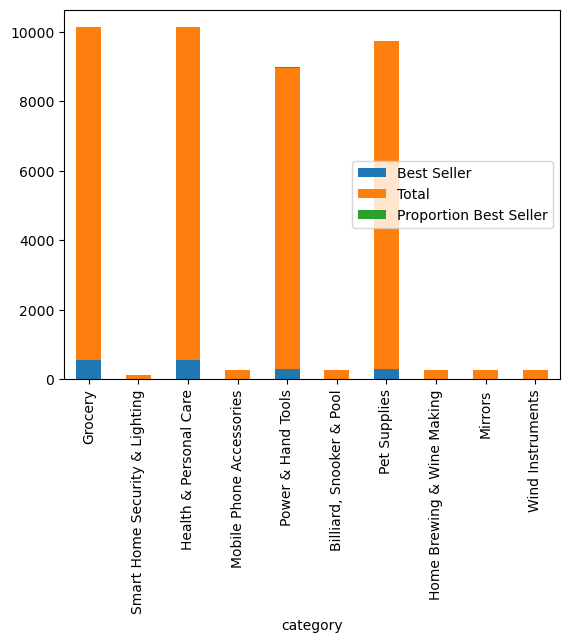

In [397]:
#3. **Visualizations**:
	#- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.
sorted_crosstab = sorted_crosstab.drop(columns=['Not Best Seller'])
sorted_crosstab = sorted_crosstab.head(10)

sorted_crosstab.plot(kind="bar", stacked=True);


### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.


In [399]:
#0. **Preliminary Step: Remove outliers in product prices.**

def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    return outliers

data_series = amazon_df['price'] 
outliers = tukeys_test_outliers(data_series)
print(outliers)

10         139.00
19         164.99
25         149.99
28         289.00
31         199.99
            ...  
2443619    166.99
2443627    152.58
2443638    108.77
2443641    166.99
2443643    158.99
Name: price, Length: 327688, dtype: float64


In [400]:
amazon_df_cleaned = amazon_df[~amazon_df['price'].isin(outliers)]
# Print the number of rows before and after removing outliers
print("Number of rows before removing outliers:", len(amazon_df))
print("Number of rows after removing outliers:", len(amazon_df_cleaned))


Number of rows before removing outliers: 2443651
Number of rows after removing outliers: 2115963


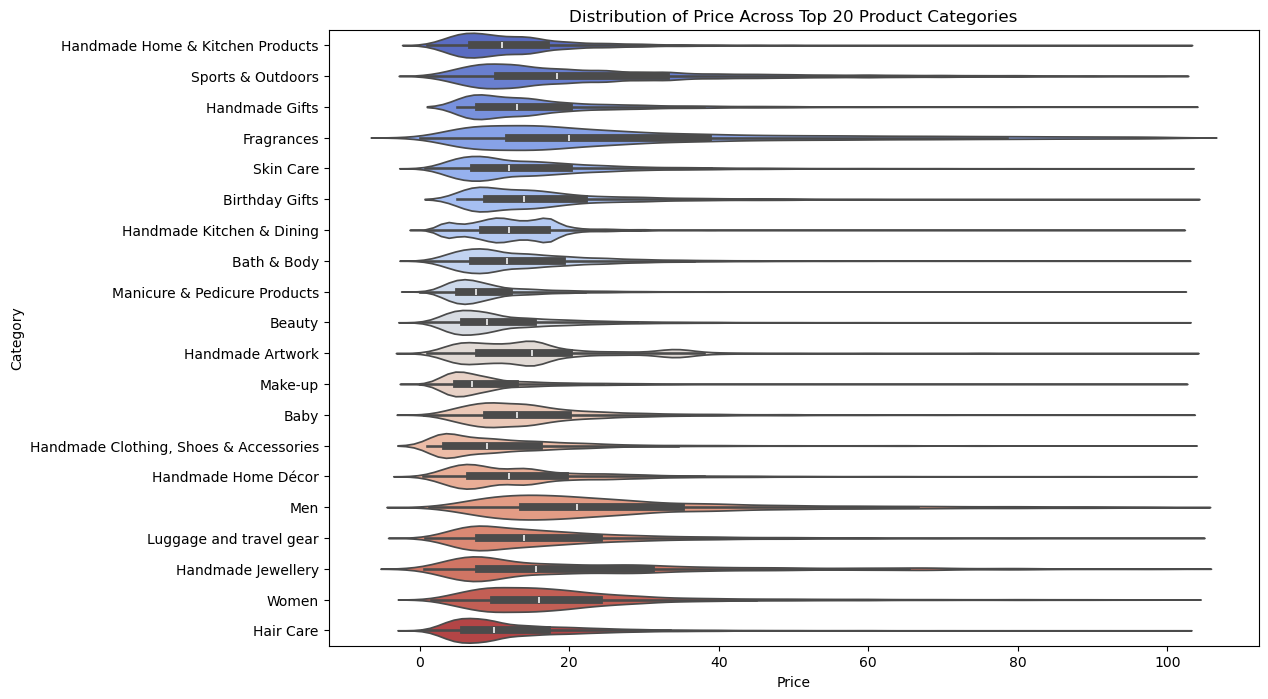

In [401]:
#Violin Plots:
#Use a violin plot to visualize the distribution of price across different product categories. 
#Filter out the top 20 categories based on count for better visualization.
#Which product category tends to have the highest median price? Don't filter here by top categories.

import seaborn as sns
import matplotlib.pyplot as plt


top_categories = amazon_df_cleaned['category'].value_counts().head(20).index
amazon_df_filtered = amazon_df_cleaned[amazon_df_cleaned['category'].isin(top_categories)]


plt.figure(figsize=(12, 8))
sns.violinplot(data=amazon_df_filtered, x='price', y='category', palette="coolwarm", hue='category', legend=False)
plt.title('Distribution of Price Across Top 20 Product Categories')
plt.xlabel('Price')
plt.ylabel('Category')
plt.show()


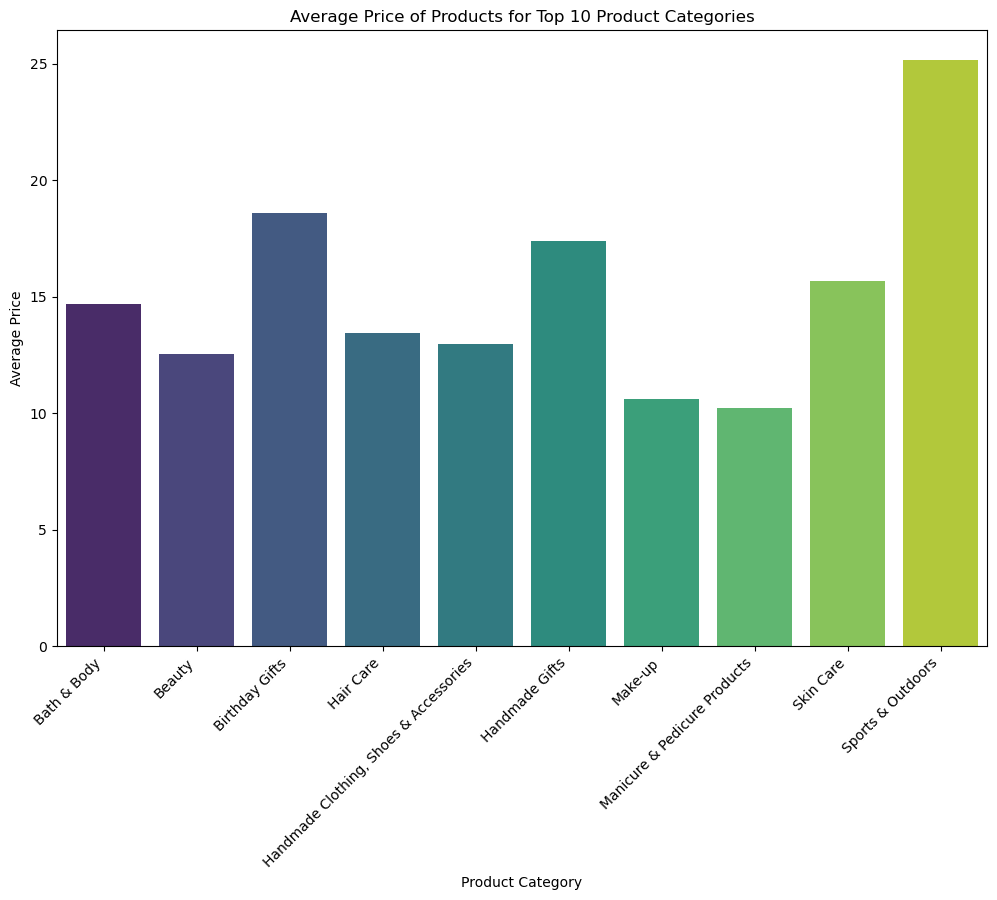

In [441]:
#Bar Charts:

#Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
#Which product category commands the highest average price? Don't filter here by top categories.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

average_prices = amazon_df_cleaned.groupby('category')['price'].mean()

top_10_categories = amazon_df_cleaned['category'].value_counts().head(10).index

amazon_df_filtered = amazon_df_cleaned[amazon_df_cleaned['category'].isin(top_10_categories)]
average_prices_filtered = amazon_df_filtered.groupby('category')['price'].mean()

plt.figure(figsize=(12, 8))
sns.barplot(x=average_prices_filtered.index, y=average_prices_filtered.values, palette="viridis", hue = average_prices_filtered.index)
plt.title('Average Price of Products for Top 10 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.show()


In [443]:
# Find the category with the highest average price
highest_avg_price_category = average_prices.idxmax()
highest_avg_price_value = average_prices.max()

print(f"The product category with the highest average price is '{highest_avg_price_category}' with an average price of {highest_avg_price_value:.2f}.")


The product category with the highest average price is 'Motherboards' with an average price of 68.77.


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Sports & Outdoors'),
  Text(1, 0, 'Handmade Gifts'),
  Text(2, 0, 'Skin Care'),
  Text(3, 0, 'Birthday Gifts'),
  Text(4, 0, 'Bath & Body'),
  Text(5, 0, 'Manicure & Pedicure Products'),
  Text(6, 0, 'Beauty'),
  Text(7, 0, 'Make-up'),
  Text(8, 0, 'Handmade Clothing, Shoes & Accessories'),
  Text(9, 0, 'Hair Care')])

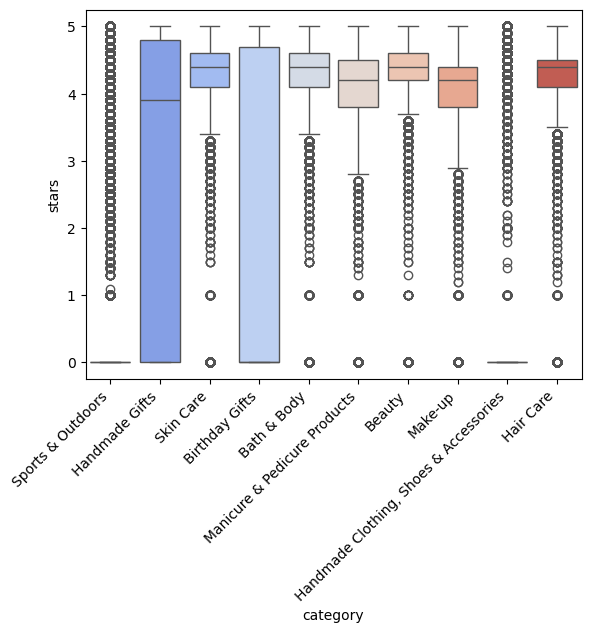

In [461]:
#Box Plots:

#Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.

sns.boxplot(data=amazon_df_filtered, x='category', y='stars', palette="coolwarm", hue='category', legend=False)
plt.xticks(rotation=45, ha='right')

In [470]:
#Which category tends to receive the highest median rating from customers? Don't filter here by top categories.
median_ratings_customer = amazon_df_cleaned.groupby('category')['stars'].median()


highest_median_ratings_customer = median_ratings_customer.idxmax()
highest_median_ratings_customer_value = median_ratings_customer.max()

print(f"The product category with the highest median rating from customers is '{highest_median_ratings_customer}' with a median of {highest_median_ratings_customer_value:.2f}.")

The product category with the highest median rating from customers is 'Computer Memory' with a median of 4.70.


### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?
	
2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

---

**Submission**: Submit a Jupyter Notebook which contains code and a business-centric report summarizing your findings. 

**Bonus**: 

- Do the same analysis without taking out the outliers. What are your insights?


In [473]:
#1. Calculate the correlation coefficient between price and stars.
correlation = amazon_df_cleaned['stars'].corr(amazon_df_cleaned['price'])
correlation

#Is there a significant correlation between product price and its rating? NO, because the correlation value is very close to 0

-0.07767299878181352

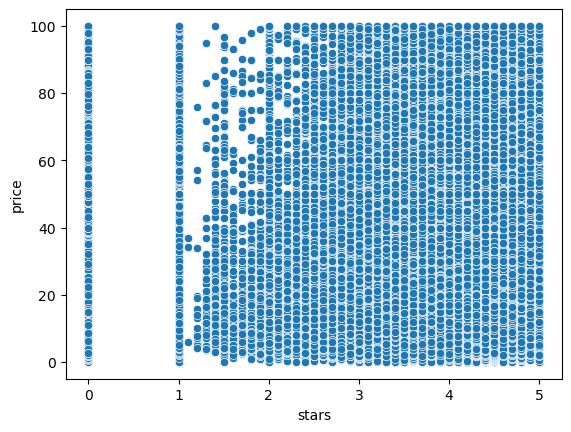

In [478]:
#2. Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe? There is no correlation at all
sns.scatterplot(data=amazon_df_cleaned, x='stars', y='price');


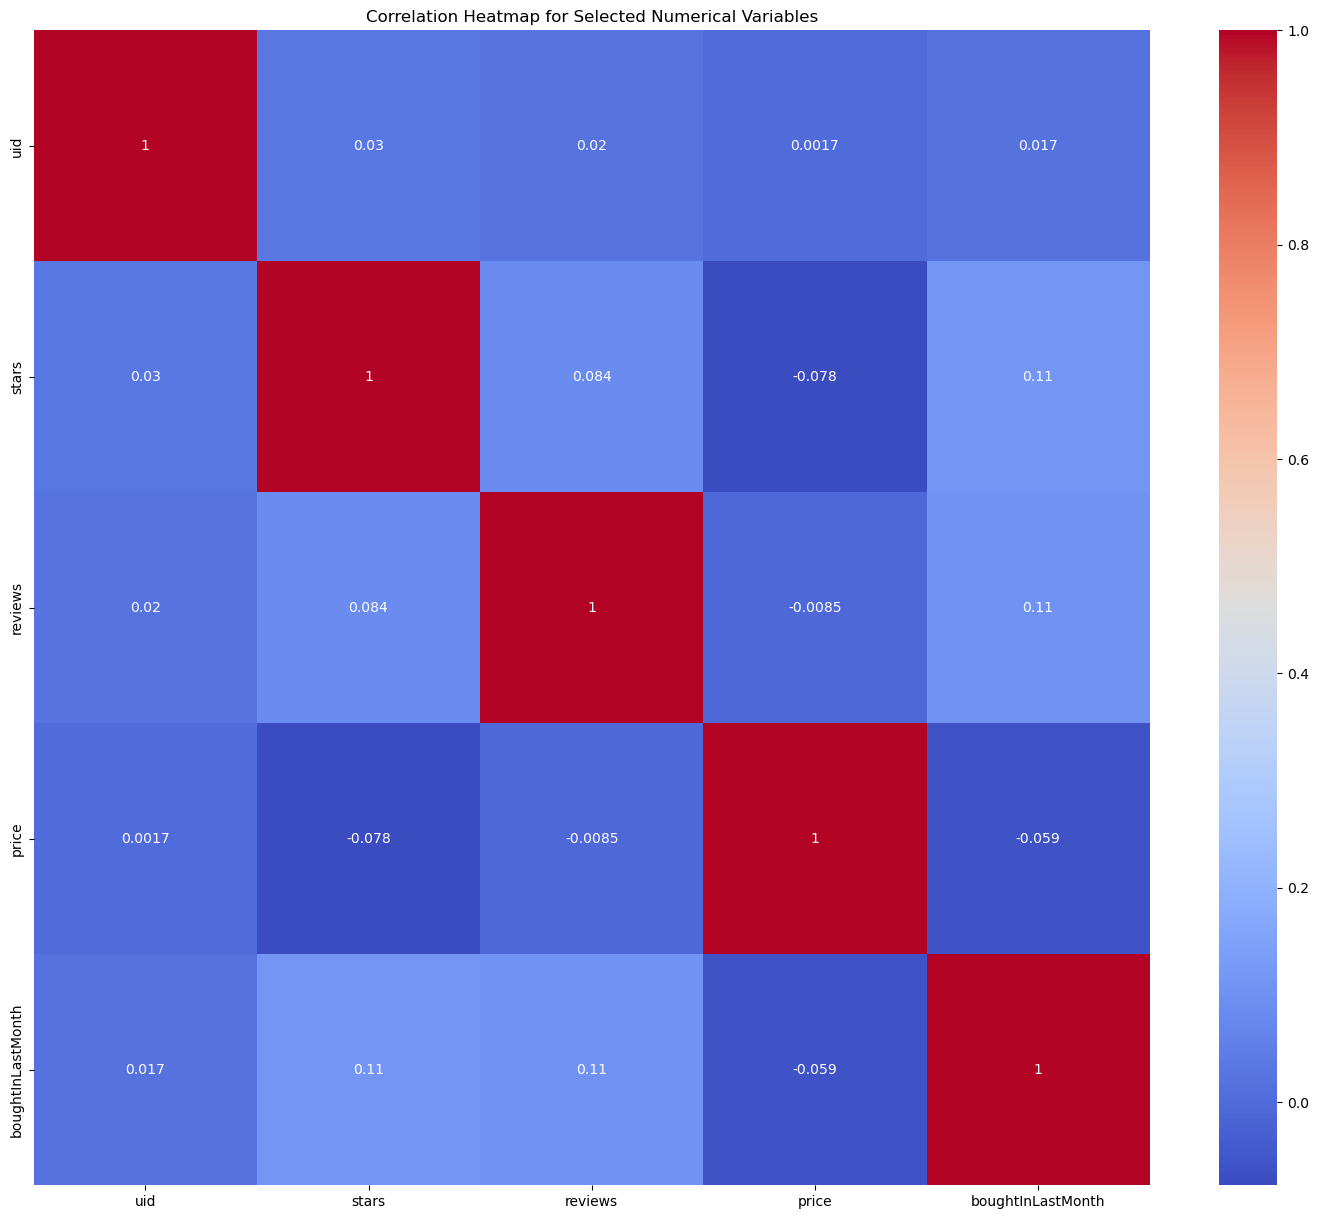

In [487]:
#Use a correlation heatmap to visualize correlations between all numerical variables.


potential_categorical_from_numerical = amazon_df_cleaned.select_dtypes("number").loc[:, amazon_df_cleaned.select_dtypes("number").nunique() < 20]
df_numerical = amazon_df_cleaned.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)


correlation_matrix = df_numerical.corr() 

plt.figure(figsize=(18, 15))


sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

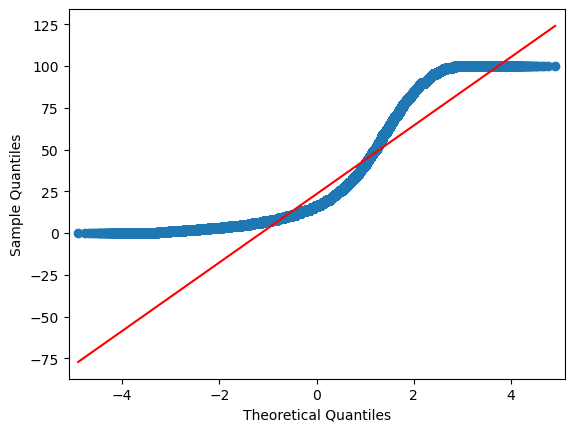

In [489]:
#Examine if product prices typically follow a normal distribution using a QQ plot.
import statsmodels.api as sm

# Generating a Q-Q plot for 'SalePrice' to check if its distribution follows a normal distribution
sm.qqplot(amazon_df_cleaned['price'], line='s');


#NOT normally distributed

In [492]:
#Bonus:
#Do the same analysis without taking out the outliers. What are your insights?

#1. Calculate the correlation coefficient between price and stars.
correlation = amazon_df['stars'].corr(amazon_df['price'])
correlation #value increases but still very low:no correlation

-0.12490673262148688

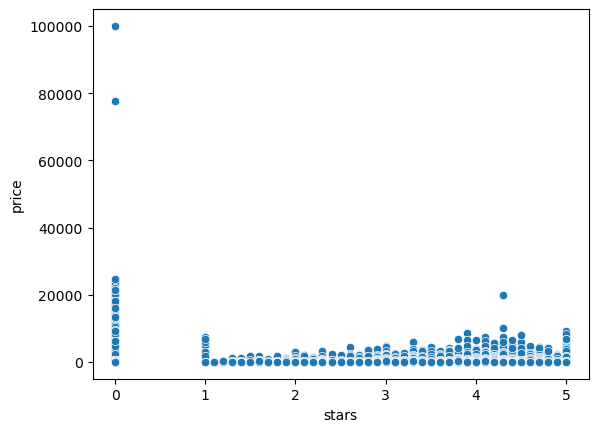

In [494]:
#2. Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe? There is no correlation at all
sns.scatterplot(data=amazon_df, x='stars', y='price');

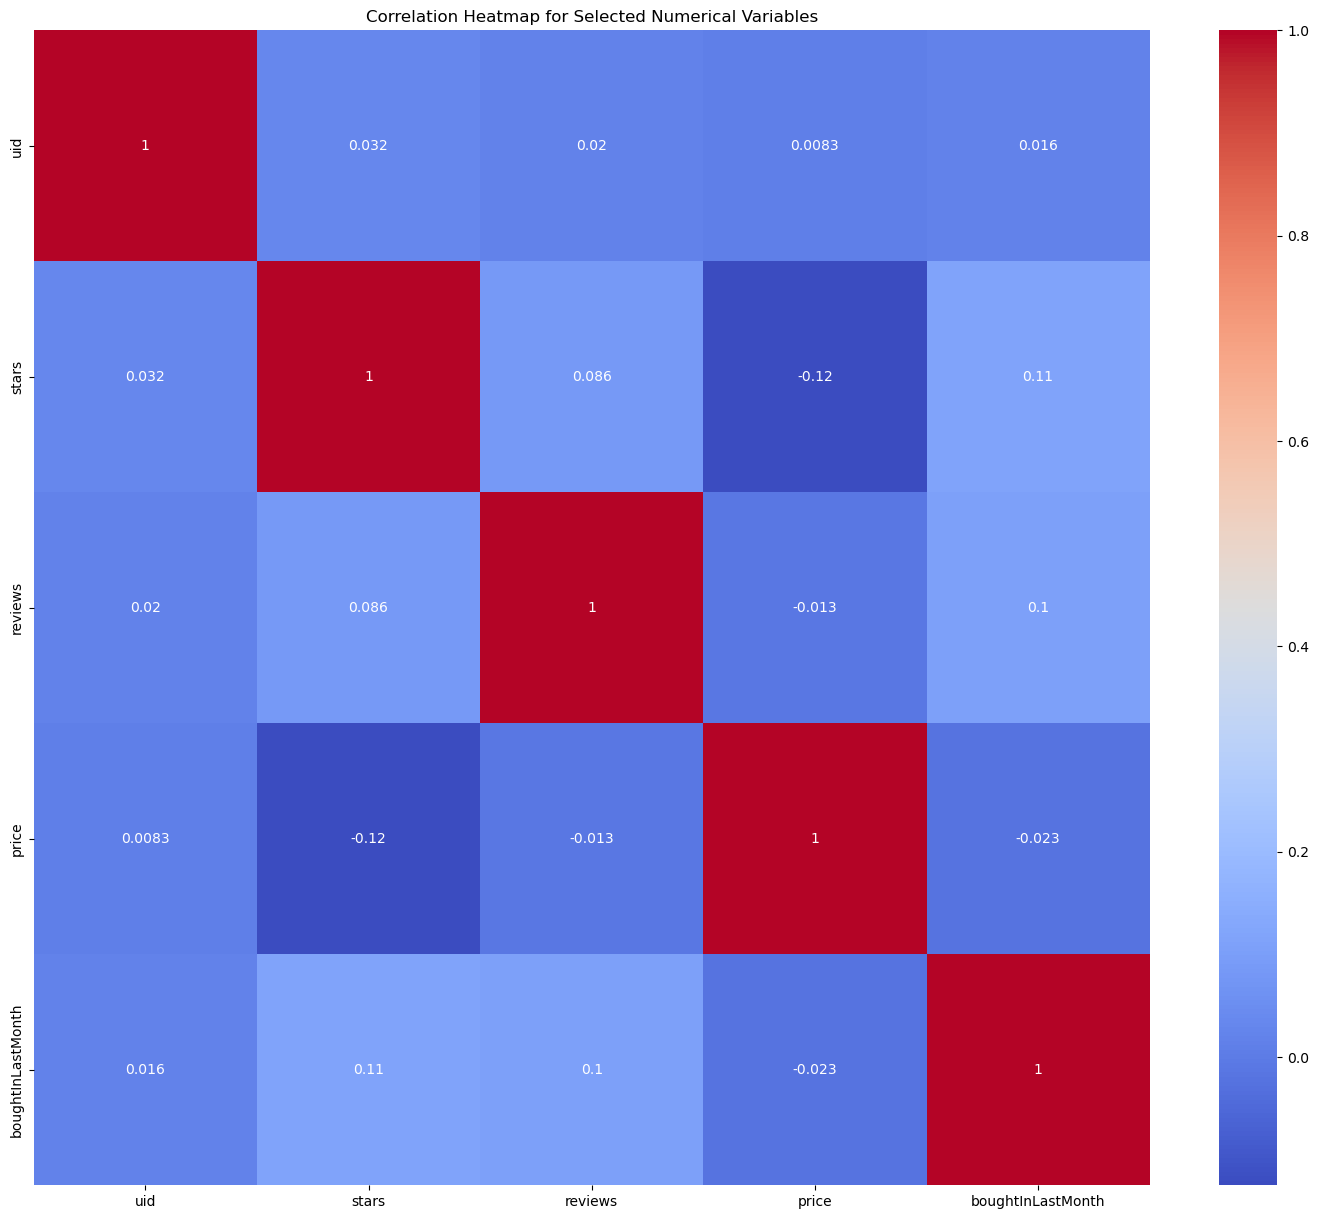

In [500]:
#Use a correlation heatmap to visualize correlations between all numerical variables.

potential_categorical_from_numerical = amazon_df.select_dtypes("number").loc[:, amazon_df.select_dtypes("number").nunique() < 20]
df_numerical = amazon_df.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)


correlation_matrix = df_numerical.corr() 

plt.figure(figsize=(18, 15))


sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()


In [496]:
#Examine if product prices typically follow a normal distribution using a QQ plot.
import statsmodels.api as sm

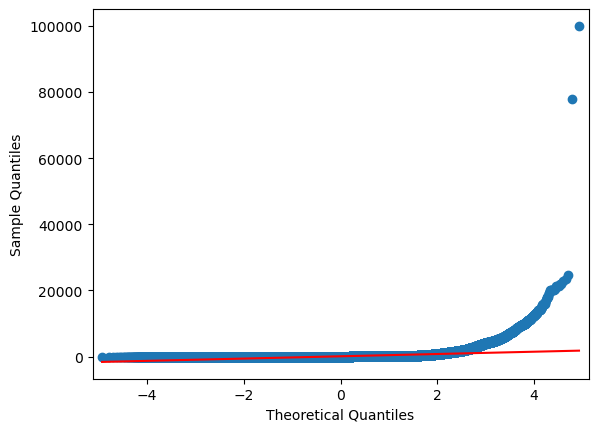

In [498]:

# Generating a Q-Q plot for 'SalePrice' to check if its distribution follows a normal distribution
sm.qqplot(amazon_df['price'], line='s');


#NOT normally distributed